In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#!unzip -qq /content/gdrive/MyDrive/cats_vs_dogs_small_dataset.zip

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras import layers
from keras import models
from keras.models import Sequential
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from keras.applications import VGG16

In [6]:
# Code to remove the data and folder created from a previous run of the data
!rm -rf "cats_vs_dogs_small"
#!rm -rf "cats_vs_dogs_small_dataset"

Number of images in train subset: 1000
Number of images in validation subset: 500
Number of images in test subset: 500
Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/10
10/10 [==============================] - 456s 47s/step - loss: 1.0915 - accuracy: 0.4870 - val_loss: 2.2585 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 452s 47s/step - loss: 0.9648 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5140
Epoch 3/10
10/10 [==============================] - 450s 47s/step - loss: 0.7159 - accuracy: 0.5320 - val_loss: 0.6872 - val_accuracy: 0.5240
Epoch 4/10
10/10 [==============================] - 449s 46s/step - loss: 0.6868 - accuracy: 0.5780 - val_loss: 0.6687 - val_accuracy: 0.5960
Epoch 5/10
10/10 [==============================] - 449s 46s/step - loss: 0.6503 - accuracy: 0.6200 - val_loss: 0.6428 - val_accuracy: 0.5260
Epoch 6/10
10/10 [==============================] - 438s 45s/step - loss: 0.5919 - accurac

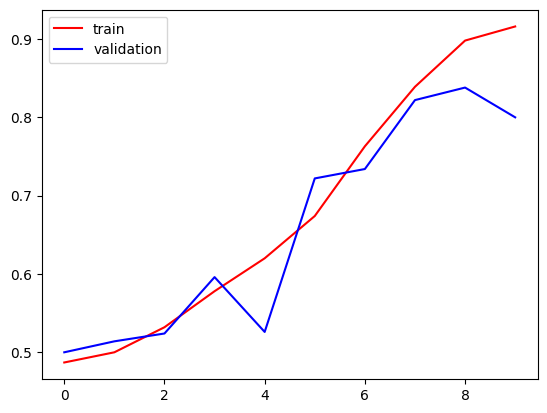

In [7]:
# Use the following code to partition the data into train/test/validation set:
import os, shutil, pathlib

original_dir = pathlib.Path("cats_vs_dogs_small_dataset")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    count = 0
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)

        fnames = [f"{i}.jpg" for i in range(start_index, end_index)]
        for fname in os.listdir(original_dir / category)[start_index:end_index]:
            shutil.copyfile(original_dir / category / fname, dir / fname)
            count += 1
    return count

train_count = make_subset("train", start_index=0, end_index=500)
validation_count = make_subset("validation", start_index=500, end_index=750)
test_count = make_subset("test", start_index=750, end_index=1000)

print(f"Number of images in train subset: {train_count}")
print(f"Number of images in validation subset: {validation_count}")
print(f"Number of images in test subset: {test_count}")

train_ds = keras.utils.image_dataset_from_directory(
    directory = pathlib.Path("cats_vs_dogs_small/train"),
    labels='inferred',
    label_mode = 'int',
    batch_size=100,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = pathlib.Path("cats_vs_dogs_small/test"),
    labels='inferred',
    label_mode = 'int',
    batch_size=64,
    image_size=(150,150)
)

def process(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

train_ds = train_ds.map(process).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(process).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Setup
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers[:15]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()